# <center> <b> <font color='blue'> Predictions </center> </b> </font>

## <font color='#1f618d'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Predictions](#3)
4. [Summary](#4)

<a name="1"></a>
## <font color='#1f618d'> <b> 1. Introduction </font> </b>

The goal is to show how predictions should be made in a time series problem.

<a name="2"></a>
## <font color='#1f618d'> <b> 2. Setup </font> </b>

We will generate synthetic data, preprocess it, and train a simple model.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

### Generating the data

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

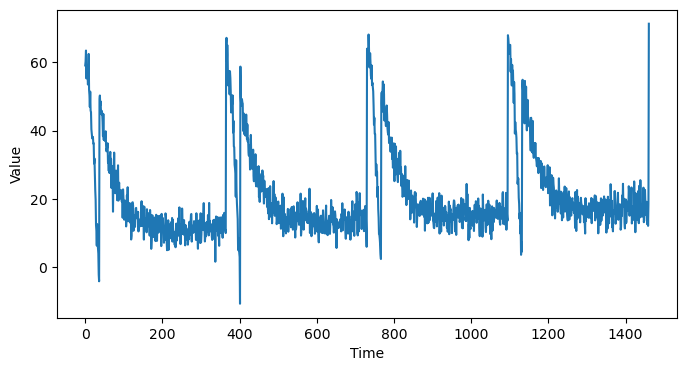

In [4]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 3
    HORIZON=1
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(8, 4))
plot_series(G.TIME, G.SERIES)
plt.show()

### Processing the data

In [5]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [6]:
def windowed_dataset(series, 
                     window_size=G.WINDOW_SIZE, 
                     horizon=G.HORIZON, 
                     batch_size=32, 
                     shuffle_buffer=10,
                     shuffle=True):
    
    # Create the dataset from the series
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Create windows of size (window_size + horizon)
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True)
    
    # Flatten the windows into batches
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon))
    
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    
    # Split the windows into features and labels
    ds = ds.map(lambda w: (w[:-horizon], w[-horizon:]))
    
    # Batch the dataset
    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# Apply the transformation to the training set and val set (horizon=1)
dataset_train = windowed_dataset(series_train)
dataset_val = windowed_dataset(series_valid, shuffle=False)

# Apply the transformation to the training set and val set (horizon=2)
dataset_train_2 = windowed_dataset(series_train, horizon=2)
dataset_val_2 = windowed_dataset(series_valid, horizon=2, shuffle=False)


### Training a model

In [7]:
tf.random.set_seed(51)

In [8]:
def create_uncompiled_model(horizon):
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(horizon),
        tf.keras.layers.Lambda(lambda x: x*100.0)
    ]) 

    return model

In [9]:
def create_model(horizon=1):

    model = create_uncompiled_model(horizon)

    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["mae"])  
    
    return model

In [10]:
model = create_model()

In [75]:
# Model 1 > horizon=1
# train the model
history = model.fit(dataset_train,
                    epochs=50, 
                    verbose=0,
                    validation_data=dataset_val)

In [76]:
data = np.array([53.53772,   54.78016,   62.50613])
model.predict(data[np.newaxis])

1/1 [==============================] - 0s 25ms/step


array([[54.66]], dtype=float32)

In [77]:
pred = model.predict(data[np.newaxis])
pred[0][0]

1/1 [==============================] - 0s 17ms/step


54.65568

### Horizon greater than 1

In [13]:
model2 = create_model(2)

In [85]:
history2 = model2.fit(dataset_train_2, 
                    epochs=50, 
                    verbose=0,
                    validation_data=dataset_val_2)

In [86]:
data = np.array([53.53772,   54.78016,   62.50613])
model2.predict(data[np.newaxis])

1/1 [==============================] - 0s 25ms/step


array([[52.70, 52.79]], dtype=float32)

In [87]:
pred = model2.predict(data[np.newaxis])
pred[0][0], pred[0][1]

1/1 [==============================] - 0s 16ms/step


(52.70196, 52.793236)

<a name="3"></a>
## <font color='#1f618d'> <b> 3. Predictions </font> </b>


### Window_size=3, horizon=1

The idea is:

- Take the initial window 
    - Which, when testing, corresponds to the last values (quantity = window size) of the training set.
- With this window, we generate a new prediction. 
- Then, we shift the window so that the last value becomes our first prediction, and we use this to predict the second value. 
- These steps are repeated until we obtain the desired number of predictions.

Our first model is trained to predict one step ahead.

In [16]:
# how many time steps to predict into the future
into_future = 4

In [79]:
# Set print options to format floats with 2 decimal places
np.set_printoptions(formatter={'float': '{:.2f}'.format})

def forecast(model, initial_window, num_predictions, verbose=False):
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window

    for _ in range(num_predictions):
        
        # Make a prediction based on the current window
        pred = model.predict(current_window[np.newaxis], verbose=0)
        predictions.append(pred[0][0])
        
        if verbose:
            print(f"Current window: {current_window}")
            print(f"Prediction: {pred[0][0]:.2f}")
            print("\n")

        # Update the window: remove the oldest value and add the new prediction
        current_window = np.roll(current_window, -1)  # Shift the window left
        current_window[-1] = pred[0][0]  # Add the new prediction at the end

    return np.array(predictions)

In [80]:
# let's generate a few predictions
initial_window = np.array([53.53772,   54.78016,   62.50613])

forecast(model, initial_window, into_future, True)

Current window: [53.54 54.78 62.51]
Prediction: 54.66


Current window: [54.78 62.51 54.66]
Prediction: 52.47


Current window: [62.51 54.66 52.47]
Prediction: 51.58


Current window: [54.66 52.47 51.58]
Prediction: 49.53




array([54.66, 52.47, 51.58, 49.53], dtype=float32)

To calculate the metrics:

- The initial window is composed of the last WINDOW_SIZE values from the training set.
- The number of predictions is equal to the length of the validation set.

In [81]:
series_train[-G.WINDOW_SIZE:]

array([65.18, 62.57, 63.61], dtype=float32)

In [82]:
preds = forecast(model, series_train[-G.WINDOW_SIZE:], len(series_valid))

In [83]:
# Calculate MAE directly using the metric function
mae = tf.keras.metrics.mean_absolute_error(series_valid, preds)
mae

<tf.Tensor: shape=(), dtype=float32, numpy=6.503756>

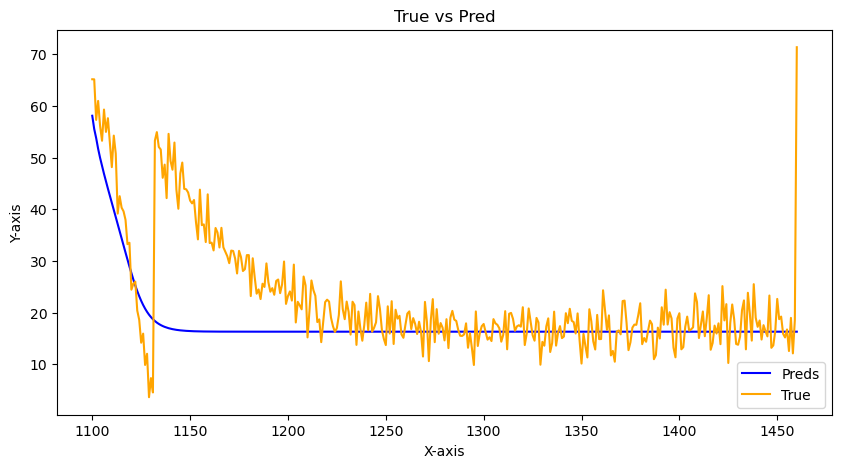

In [84]:
# Plotting
plt.figure(figsize=(10, 5))  # Optional: Set the figure size
plt.plot(time_valid, preds, label='Preds', color='blue')  # Plot the first array
plt.plot(time_valid, series_valid, label='True', color='orange')  # Plot the second array

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('True vs Pred')
plt.legend()  # Show legend

# Show the plot
plt.show()

### Window_size=3, horizon=2

The idea is:

- Take the initial window 
    - Which, when testing, corresponds to the last values (quantity = window size) of the training set. 
- With whis window, we generate a new set of predictions based on the horizon (number of steps ahead the model predicts). 
- After making the predictions, we shift the window so that the last values of the predictions replace the oldest values in the window. 
- This process is repeated until we obtain the desired number of predictions.

Our second model is trained to predict 2 steps ahead.

In [32]:
# how many time steps to predict into the future
into_future = 4

We need to generalize our previous function for multi-step predictions:

In [88]:
def forecast(model, initial_window, num_predictions, horizon=G.HORIZON, verbose=False):
    """
    Forecast future values using a model with multi-step horizon predictions.
    
    Args:
        model: The trained model used for predictions.
        initial_window: The starting data window.
        num_predictions: The total number of steps to predict.
        horizon: The number of steps the model predicts in each iteration (e.g., 2 for 2 steps ahead).
        verbose: If True, prints details about the current window and predictions.
        
    Returns:
        A NumPy array of predicted values.
    """
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window
    

    # Make predictions until the desired number is reached
    while len(predictions) < num_predictions:
        
        # Make a prediction for multiple steps ahead
        pred = model.predict(current_window[np.newaxis], verbose=0)
        pred_steps = pred[0][:horizon]  # Extract the predicted steps

        # Add the predictions to the list, but ensure we don't exceed num_predictions
        steps_to_add = min(horizon, num_predictions - len(predictions))
        predictions.extend(pred_steps[:steps_to_add])
        
        if verbose:
            print(f"Current window: {current_window}")
            print(f"Predictions: {pred_steps[:steps_to_add]}")
            print("\n")

        # Update the window: remove the oldest values and add the new predictions
        current_window = np.roll(current_window, -steps_to_add)  # Shift left by the number of steps added
        current_window[-steps_to_add:] = pred_steps[:steps_to_add]  # Insert the new predictions at the end

    return np.array(predictions[:num_predictions])  # Return exactly num_predictions values


In [89]:
# let's generate a few predictions
initial_window = np.array([53.53772,   54.78016,   62.50613])

forecast(model2, initial_window, into_future, 2, True)

Current window: [53.54 54.78 62.51]
Predictions: [52.70 52.79]


Current window: [62.51 52.70 52.79]
Predictions: [51.18 50.85]




array([52.70, 52.79, 51.18, 50.85], dtype=float32)

In [90]:
series_train[-G.WINDOW_SIZE:]

array([65.18, 62.57, 63.61], dtype=float32)

In [93]:
preds = forecast(model2, series_train[-G.WINDOW_SIZE:], len(series_valid))

In [94]:
# Calculate MAE directly using the metric function
mae = tf.keras.metrics.mean_absolute_error(series_valid, preds)
mae

<tf.Tensor: shape=(), dtype=float32, numpy=6.7008586>

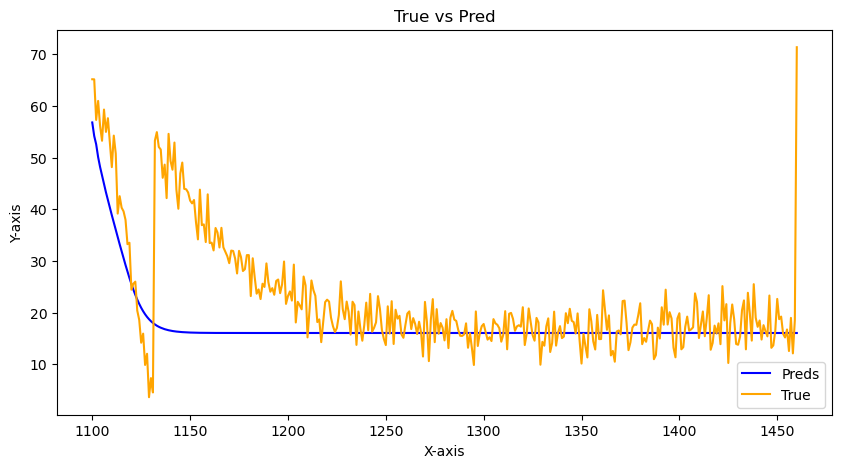

In [95]:
# Plotting
plt.figure(figsize=(10, 5))  # Optional: Set the figure size
plt.plot(time_valid, preds, label='Preds', color='blue')  # Plot the first array
plt.plot(time_valid, series_valid, label='True', color='orange')  # Plot the second array

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('True vs Pred')
plt.legend()  # Show legend

# Show the plot
plt.show()

<a name="4"></a>
## <font color='#1f618d'> <b> 4. Summary </font> </b>

We can use the following function to make predictions:

In [74]:
def forecast(model, initial_window, num_predictions, horizon=G.HORIZON, verbose=False):
    """
    Forecast future values using a model with multi-step horizon predictions.
    
    Args:
        model: The trained model used for predictions.
        initial_window: The starting data window.
        num_predictions: The total number of steps to predict.
        horizon: The number of steps the model predicts in each iteration (e.g., 2 for 2 steps ahead).
        verbose: If True, prints details about the current window and predictions.
        
    Returns:
        A NumPy array of predicted values.
    """
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window
    

    # Make predictions until the desired number is reached
    while len(predictions) < num_predictions:
        
        # Make a prediction for multiple steps ahead
        pred = model.predict(current_window[np.newaxis], verbose=0)
        pred_steps = pred[0][:horizon]  # Extract the predicted steps

        # Add the predictions to the list, but ensure we don't exceed num_predictions
        steps_to_add = min(horizon, num_predictions - len(predictions))
        predictions.extend(pred_steps[:steps_to_add])
        
        if verbose:
            print(f"Current window: {current_window}")
            print(f"Predictions: {pred_steps[:steps_to_add]}")
            print("\n")

        # Update the window: remove the oldest values and add the new predictions
        current_window = np.roll(current_window, -steps_to_add)  # Shift left by the number of steps added
        current_window[-steps_to_add:] = pred_steps[:steps_to_add]  # Insert the new predictions at the end

    return np.array(predictions[:num_predictions])  # Return exactly num_predictions values


estrategias -> re-entrenar el modelo en cada  paso; varios modelos para varios pasos de tiempo


tmb. hacer los dibujos


In [22]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

Function which takes as input:
a list of values (the Bitcoin historical data)
a trained model (such as model_9)
a window into the future to predict (our INTO_FUTURE variable)
the window size a model was trained on (WINDOW_SIZE) - the model can only predict on the same kind of data it was trained on
Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last WINDOW_SIZE values from the input values (predictions will start from the last WINDOW_SIZE values of the training data)
Loop INTO_FUTURE times making a prediction on WINDOW_SIZE datasets which update to remove the first the value and append the latest prediction
Eventually future predictions will be made using the model's own previous predictions as input

In [29]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=G.WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-window_size:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-window_size:]
  
  return future_forecast

So perhaps you could try to: make a prediction (one timestep into the future), retrain a model with this new prediction appended to the data, make a prediction, append the prediction, retrain a model... etc.

As it is, the make_future_forecasts() function skips the retraining of a model part

In [30]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts 
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=series_train,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=G.WINDOW_SIZE)

1/1 [==============================] - 1s 1s/step
Predicting on: 
 [15.644012 21.572624 21.997427 12.678073 16.904451 13.923784 17.233252
 14.982596 12.443837 13.33335  21.776484 10.975533 16.485495 14.617779
 13.646269 67.99623  66.97603  65.180084 62.56855  63.612823] -> Prediction: 65.07779693603516

1/1 [==============================] - 0s 22ms/step
Predicting on: 
 [21.572624 21.997427 12.678073 16.904451 13.923784 17.233252 14.982596
 12.443837 13.33335  21.776484 10.975533 16.485495 14.617779 13.646269
 67.99623  66.97603  65.180084 62.56855  63.612823 65.0778  ] -> Prediction: 63.21601104736328

1/1 [==============================] - 0s 21ms/step
Predicting on: 
 [21.997427 12.678073 16.904451 13.923784 17.233252 14.982596 12.443837
 13.33335  21.776484 10.975533 16.485495 14.617779 13.646269 67.99623
 66.97603  65.180084 62.56855  63.612823 65.0778   63.21601 ] -> Prediction: 60.87576675415039

1/1 [==============================] - 0s 28ms/step
Predicting on: 
 [12.678073 16

#### si el horizonte fuese mayor a 1 remplazo por más valores